In [1]:
import numpy as np
import pandas
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import imblearn

In [2]:
#read the kddcup99 file into a dataframe

kddcup99 = pandas.read_csv('kddcup99.csv')

In [3]:
#add a mew column and classify whether the attack is a probe or not based on the label

def probe_class(label):
    if label in ['ipsweep', 'nmap', 'portsweep', 'satan']:
        return 1
    else:
        return 0

#adding the new column as well as filtering out the normal data and dropping the labels    
kddcup99['probe'] = kddcup99['label'].apply(probe_class)
kddcup99_filtered = kddcup99[kddcup99['label'] != 'normal']
kddcup99_filtered = kddcup99_filtered.drop('label', axis=1)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler

#set up features and target data
X = kddcup99_filtered.drop('probe', axis=1)  # features
y = kddcup99_filtered['probe']  # target

#encode the string categories using one hot encoder
categorical_cols = ['protocol_type', 'service', 'flag']
encoder = OneHotEncoder(categories='auto', sparse_output=False)
X_encoded = encoder.fit_transform(X[categorical_cols])

#split the data into training and testing (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2)

#balance the data sampling using RUS
RUS = RandomUnderSampler()
X_train_resampled, y_train_resampled = RUS.fit_resample(X_train, y_train)

#logitsic regression with one vs rest parameter
lr = LogisticRegression(multi_class='ovr')
lr.fit(X_train_resampled, y_train_resampled)
y_train_pred = lr.predict(X_train_resampled)
y_pred = lr.predict(X_test)

print('Misclassification examples: %d' % (y_test != y_pred).sum())
print('Train accuracy: %.3f' % lr.score(X_train_resampled, y_train_resampled))
print('Test accuracy: %.3f' % lr.score(X_test, y_test))
print(f'Number of Iterations to Converge: {lr.n_iter_[0]}')

Misclassification examples: 4463
Train accuracy: 0.967
Test accuracy: 0.944
Number of Iterations to Converge: 55


In [5]:
# My training accuracy is 94 - 97%
# My testing accruracy is also 94 - 97%
# I do not think my model is overfit because the testing and training accuracies are similar. If the model is overfit, the testing accuracy would be significantly lower compared to my training accuracy. 
# It takes about 50-60 iterations to converage. 

In [8]:
# decode the features and find the absolute coefficients of the model
encoder = OneHotEncoder(categories='auto', sparse_output=False)
encoder.fit(X[categorical_cols])
decoded_feature_names = encoder.get_feature_names_out(input_features=categorical_cols)
abs_coef = np.abs(lr.coef_[0])

#sort the features by magnitude
sorted_indices = np.argsort(abs_coef)[::-1]
sorted_features = decoded_feature_names[sorted_indices]

#print
for feature, coef in zip(sorted_features[:5], abs_coef[sorted_indices][:5]):
    print(f"Feature: {feature}, Coefficient: {coef:.4f}")

Feature: service_ecr_i, Coefficient: 6.0276
Feature: service_other, Coefficient: 5.2311
Feature: service_eco_i, Coefficient: 4.8620
Feature: flag_S0, Coefficient: 4.2613
Feature: flag_RSTR, Coefficient: 3.4298


In [9]:
# The lnum_shells and lnum_file_creations were the two largest coefficients. To me, this doesn't make much sense since most of the values for these features were zero. 

#The service and srv_serror_rate are the 3rd and 4th most signification. These features make sense since the protocol targeted and error rates are defining features of different attacks. 

Testing Accuracy (L1): 0.943
Testing Accuracy (L2): 0.944


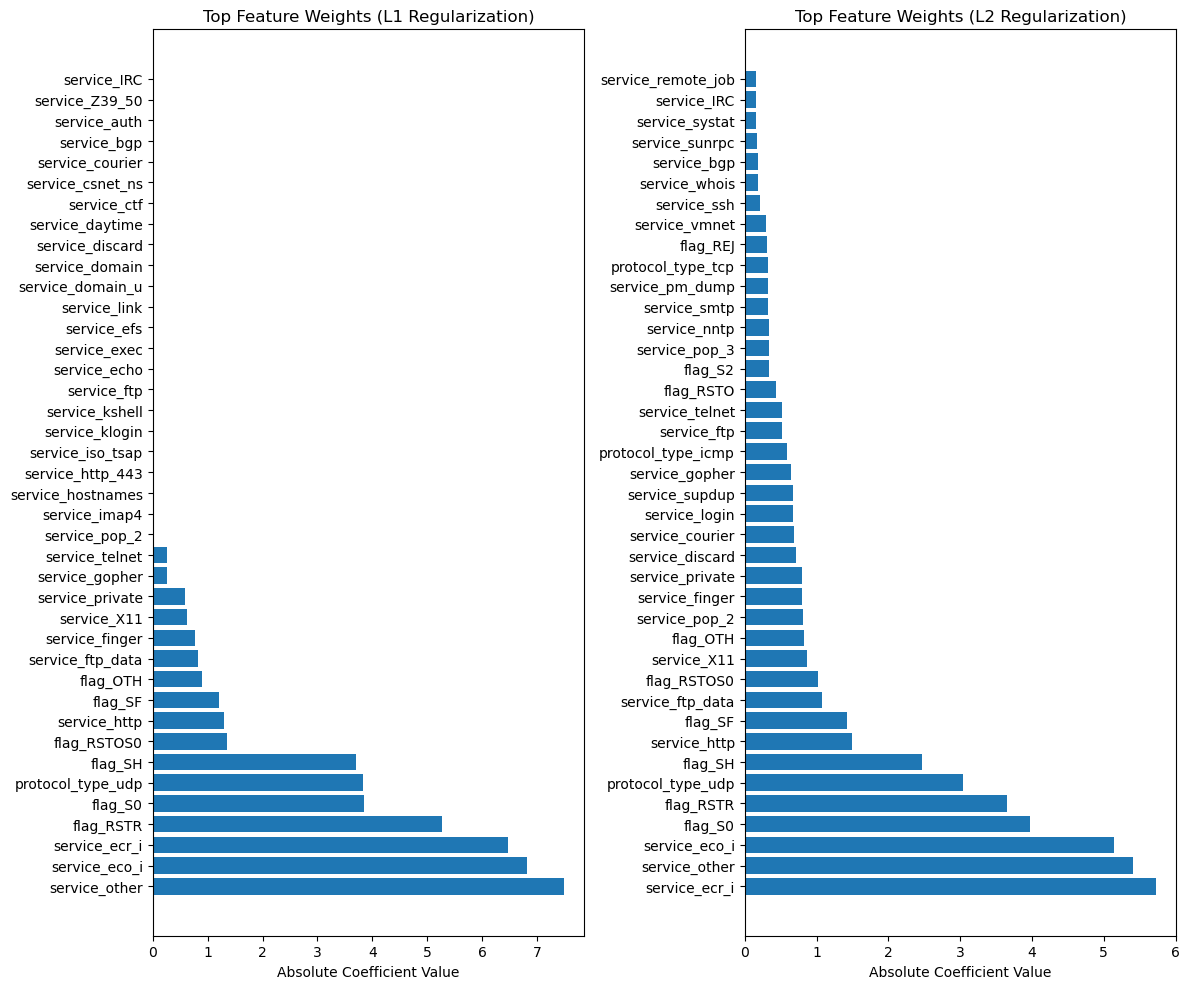

In [10]:
#Train with L1 and L2 regularizations

lr_l1 = LogisticRegression(penalty='l1', C=1, solver='liblinear')
lr_l2 = LogisticRegression(penalty='l2', C=1, solver='liblinear')

lr_l1.fit(X_train_resampled, y_train_resampled)
lr_l2.fit(X_train_resampled, y_train_resampled)

y_pred_l1 = lr_l1.predict(X_test)
y_pred_l2 = lr_l2.predict(X_test)

print(f'Testing Accuracy (L1): %.3f' % lr_l1.score(X_test, y_test))
print(f'Testing Accuracy (L2): %.3f' % lr_l2.score(X_test, y_test))

encoder = OneHotEncoder(categories='auto', sparse_output=False)
encoder.fit(X[categorical_cols])
decoded_feature_names = encoder.get_feature_names_out(input_features=categorical_cols)

# Get the absolute values of feature weights (coefficients) for both models
coef_abs_l1 = np.abs(lr_l1.coef_[0])
coef_abs_l2 = np.abs(lr_l2.coef_[0])

# Get the indices that sort the coefficients in descending order
sorted_indices_l1 = np.argsort(coef_abs_l1)[::-1]
sorted_indices_l2 = np.argsort(coef_abs_l2)[::-1]

# Get the corresponding feature names based on sorted indices
sorted_feature_names_l1 = decoded_feature_names[sorted_indices_l1]
sorted_feature_names_l2 = decoded_feature_names[sorted_indices_l2]

# Set a larger figure size
plt.figure(figsize=(12, 10))

# Plot the top N feature weights for both L1 and L2 regularization
N = 40  # Number of top features to display

plt.subplot(121)
plt.barh(range(N), coef_abs_l1[sorted_indices_l1][:N])
plt.yticks(range(N), sorted_feature_names_l1[:N])
plt.title('Top Feature Weights (L1 Regularization)')
plt.xlabel('Absolute Coefficient Value')

plt.subplot(122)
plt.barh(range(N), coef_abs_l2[sorted_indices_l2][:N])
plt.yticks(range(N), sorted_feature_names_l2[:N])
plt.title('Top Feature Weights (L2 Regularization)')
plt.xlabel('Absolute Coefficient Value')

plt.tight_layout()
plt.show()



In [11]:
# The accuracies are the same between L1 and L2 regularization. Main difference is L1 push more coefs to exact zero and effctively removing them from the model. 
# L2 retains all features and more evenly distributre the coefs. This helps prevent overfitting by reducing the overall magnitudes of the coef but not removing them. 

In [12]:
#inverse strength = 10
lr_l2_1 = LogisticRegression(penalty='l2', C=10, solver='liblinear')
lr_l2_1.fit(X_train_resampled, y_train_resampled)
y_pred_l2_1 = lr_l2_1.predict(X_test)
print(f'Train Accuracy (L2) with C = 10: %.3f' % lr_l2_1.score(X_train_resampled, y_train_resampled))
print(f'Testing Accuracy (L2) with C = 10: %.3f' % lr_l2_1.score(X_test, y_test))

#inverse strength = 1
lr_l2_2 = LogisticRegression(penalty='l2', C=1, solver='liblinear')
lr_l2_2.fit(X_train_resampled, y_train_resampled)
y_pred_l2_2 = lr_l2_2.predict(X_test)
print(f'Train Accuracy (L2) with C = 1: %.3f' % lr_l2_2.score(X_train_resampled, y_train_resampled))
print(f'Testing Accuracy (L2) with C = 1: %.3f' % lr_l2_2.score(X_test, y_test))

#inverse strength = 0.1
lr_l2_3 = LogisticRegression(penalty='l2', C=0.1, solver='liblinear')
lr_l2_3.fit(X_train_resampled, y_train_resampled)
y_pred_l2_3 = lr_l2_3.predict(X_test)
print(f'Train Accuracy (L2) with C = 0.1: %.3f' % lr_l2_3.score(X_train_resampled, y_train_resampled))
print(f'Testing Accuracy (L2) with C = 0.1: %.3f' % lr_l2_3.score(X_test, y_test))

#inverse strength = 0.01
lr_l2_4 = LogisticRegression(penalty='l2', C=0.01, solver='liblinear')
lr_l2_4.fit(X_train_resampled, y_train_resampled)
y_pred_l2_4 = lr_l2_4.predict(X_test)
print(f'Train Accuracy (L2) with C = 0.01: %.3f' % lr_l2_4.score(X_train_resampled, y_train_resampled))
print(f'Testing Accuracy (L2) with C = 0.01: %.3f' % lr_l2_4.score(X_test, y_test))

#inverse strength = 0.001
lr_l2_5 = LogisticRegression(penalty='l2', C=0.001, solver='liblinear')
lr_l2_5.fit(X_train_resampled, y_train_resampled)
y_pred_l2_5 = lr_l2_5.predict(X_test)
print(f'Train Accuracy (L2) with C = 0.001: %.3f' % lr_l2_5.score(X_train_resampled, y_train_resampled))
print(f'Testing Accuracy (L2) with C = 0.001: %.3f' % lr_l2_5.score(X_test, y_test))

Train Accuracy (L2) with C = 10: 0.968
Testing Accuracy (L2) with C = 10: 0.943
Train Accuracy (L2) with C = 1: 0.967
Testing Accuracy (L2) with C = 1: 0.944
Train Accuracy (L2) with C = 0.1: 0.963
Testing Accuracy (L2) with C = 0.1: 0.936
Train Accuracy (L2) with C = 0.01: 0.963
Testing Accuracy (L2) with C = 0.01: 0.936
Train Accuracy (L2) with C = 0.001: 0.937
Testing Accuracy (L2) with C = 0.001: 0.926


In [13]:
# The accuracy slowly does down as C decreases. This is caused by stronger regularization when C is smaller. This creates higher penalties to larger coeffs. The decision boundary is simipler which might cause data underfitting
# As C increaes, the model becomes more accurate. The regularization is weaker as C increases. The model fit closer to the data but there is a higher chance of overfit. 